Microbiome series shape: (100, 12, 5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 11, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11, 5)          │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,245 (71.27 KB)

 Trainable params: 18,245 (71.27 KB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


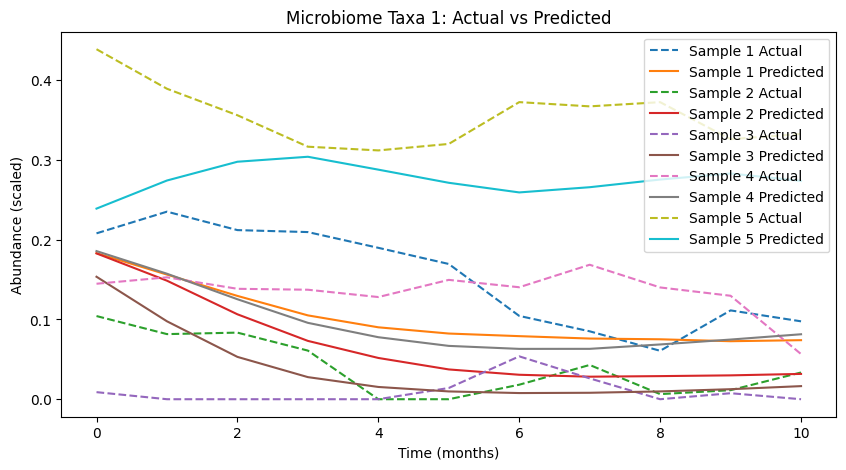

In [1]:
# Microbiome Time Traveler Demo - Full Workflow in 1 Cell
# This demo predicts future microbiome abundances using synthetic longitudinal data

!pip install -q matplotlib seaborn tensorflow numpy pandas plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# --------------------------
# 1. Generate synthetic microbiome time-series data
# --------------------------
np.random.seed(42)
time_points = 12  # months
samples = 100
taxa = 5  # number of microbial taxa

# Random initial abundances
data = np.random.rand(samples, taxa)
data = data / data.sum(axis=1, keepdims=True)

# Simulate monthly changes
microbiome_series = []
for t in range(time_points):
    noise = np.random.normal(0, 0.02, size=(samples, taxa))
    if t == 0:
        microbiome_series.append(data)
    else:
        new_data = microbiome_series[-1] + noise
        new_data[new_data < 0] = 0
        new_data = new_data / new_data.sum(axis=1, keepdims=True)
        microbiome_series.append(new_data)

microbiome_series = np.stack(microbiome_series, axis=1)  # shape: samples x time x taxa
print(f"Microbiome series shape: {microbiome_series.shape}")

# --------------------------
# 2. Prepare data for LSTM
# --------------------------
X = microbiome_series[:, :-1, :]  # months 0-10
y = microbiome_series[:, 1:, :]   # months 1-11 (next month prediction)

# Scale data
scaler = MinMaxScaler()
X_scaled = X.reshape(-1, taxa)
y_scaled = y.reshape(-1, taxa)
X_scaled = scaler.fit_transform(X_scaled).reshape(samples, time_points-1, taxa)
y_scaled = scaler.transform(y_scaled).reshape(samples, time_points-1, taxa)

# --------------------------
# 3. Build LSTM model
# --------------------------
model = Sequential([
    LSTM(64, activation='relu', input_shape=(time_points-1, taxa), return_sequences=True),
    Dense(taxa, activation='softmax')
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# --------------------------
# 4. Train model
# --------------------------
history = model.fit(X_scaled, y_scaled, epochs=50, batch_size=16, verbose=0)

# --------------------------
# 5. Predict future microbiome (next 1 month)
# --------------------------
pred = model.predict(X_scaled)  # shape: samples x time-1 x taxa
pred_next_month = pred[:, -1, :]  # last time point prediction

# --------------------------
# 6. Visualization
# --------------------------
# Example: plot first 5 samples for first taxa
plt.figure(figsize=(10,5))
for i in range(5):
    plt.plot(range(time_points-1), y_scaled[i,:,0], label=f'Sample {i+1} Actual', linestyle='--')
    plt.plot(range(time_points-1), pred[i,:,0], label=f'Sample {i+1} Predicted', linestyle='-')
plt.xlabel("Time (months)")
plt.ylabel("Abundance (scaled)")
plt.title("Microbiome Taxa 1: Actual vs Predicted")
plt.legend()
plt.show()

# Interactive plot for all taxa for first sample
df_plot = pd.DataFrame(pred[0,:,:], columns=[f'Taxa_{i+1}' for i in range(taxa)])
df_plot['Month'] = range(1, time_points)
fig = px.line(df_plot, x='Month', y=[f'Taxa_{i+1}' for i in range(taxa)], title='Predicted Microbiome Trajectories (Sample 1)')
fig.show()
